# Two-Layer QG Model Example

Here is a quick overview of how to use the two-layer model. See the
:py:class:`pyqg.QGModel` api documentation for further details.

First import numpy, matplotlib, and pyqg:

In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

#import pyqg
import sys
sys.path.insert(0, '/home/zl1574/subgrid_closures')
from pyqg_up_to_date import pyqg

from pyqg import diagnostic_tools as tools

## Initialize and Run the Model ##

Here we set up a model which will run for 10 years and start averaging
after 5 years. There are lots of parameters that can be specified as
keyword arguments but we are just using the defaults.

In [2]:
year = 24*60*60*360.
m = pyqg.QGModel(tmax=10*year, twrite=10000, tavestart=5*year)
m.run()

INFO:  Logger initialized
INFO: Step: 10000, Time: 7.20e+07, KE: 3.61e-04, CFL: 0.075
INFO: Step: 20000, Time: 1.44e+08, KE: 5.02e-04, CFL: 0.106
INFO: Step: 30000, Time: 2.16e+08, KE: 4.88e-04, CFL: 0.087
INFO: Step: 40000, Time: 2.88e+08, KE: 5.32e-04, CFL: 0.083


## Convert Model Outpt to an xarray Dataset ##

Model variables, coordinates, attributes, and metadata can be stored conveniently as an xarray Dataset. (Notice that this feature requires xarray to be installed on your machine. See here for installation instructions: http://xarray.pydata.org/en/stable/getting-started-guide/installing.html#instructions)

In [3]:
m_ds = m.to_dataset().isel(time=-1)
m_ds

<xarray.Dataset>
Dimensions:            (lev: 2, y: 64, x: 64, l: 64, k: 33, lev_mid: 1)
Coordinates:
    time               float64 3.11e+08
  * lev                (lev) int64 1 2
  * lev_mid            (lev_mid) float64 1.5
  * x                  (x) float64 7.812e+03 2.344e+04 ... 9.766e+05 9.922e+05
  * y                  (y) float64 7.812e+03 2.344e+04 ... 9.766e+05 9.922e+05
  * l                  (l) float64 0.0 6.283e-06 ... -1.257e-05 -6.283e-06
  * k                  (k) float64 0.0 6.283e-06 ... 0.0001948 0.0002011
Data variables: (12/32)
    q                  (lev, y, x) float64 1.721e-05 1.542e-05 ... -2.323e-06
    u                  (lev, y, x) float64 -0.02068 -0.02782 ... -0.0003869
    v                  (lev, y, x) float64 0.01455 0.05014 ... 0.0006785
    ufull              (lev, y, x) float64 0.004318 -0.002825 ... -0.0003869
    vfull              (lev, y, x) float64 0.01455 0.05014 ... 0.0006785
    qh                 (lev, l, k) complex128 (0.002388329365457963+0j) ... (...
    ...                 ...
    KEflux             (l, k) float64 0.0 -9.82e-09 ... 9.762e-20 1.693e-24
    APEgenspec         (l, k) float64 0.0 -9.317e-08 ... 4.532e-36 -9.761e-47
    APEgen             float64 6.902e-11
    ENSflux            (l, k) float64 0.0 3.523e-16 ... 4.26e-27 8.052e-32
    ENSgenspec         (l, k) float64 0.0 -4.141e-16 ... 2.014e-44 -4.338e-55
    ENSfrictionspec    (l, k) float64 0.0 -1.123e-16 ... -4.466e-43 -1.938e-52
Attributes: (12/23)
    pyqg:beta:       1.5e-11
    pyqg:delta:      0.25
    pyqg:del2:       0.8
    pyqg:dt:         7200.0
    pyqg:filterfac:  23.6
    pyqg:L:          1000000.0
    ...              ...
    pyqg:tc:         43200
    pyqg:tmax:       311040000.0
    pyqg:twrite:     10000
    pyqg:W:          1000000.0
    title:           pyqg: Python Quasigeostrophic Model
    reference:       https://pyqg.readthedocs.io/en/latest/index.html

## Visualize Output ##

Let's assign a new data variable, ``q_upper``, as the **upper layer PV anomaly**. We access the PV values in the Dataset as ``m_ds.q``, which has two levels and a corresponding background PV gradient, ``m_ds.Qy``.

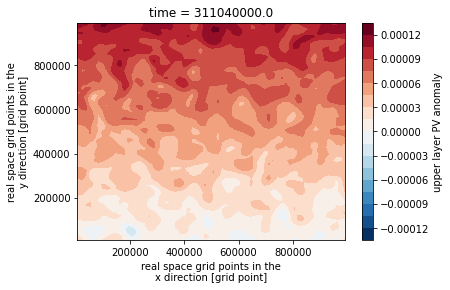

In [4]:
m_ds['q_upper'] = m_ds.q.isel(lev=0) + m_ds.Qy.isel(lev=0)*m_ds.y
m_ds['q_upper'].attrs = {'long_name': 'upper layer PV anomaly'}
m_ds.q_upper.plot.contourf(levels=18, cmap='RdBu_r');

## Plot Diagnostics ##

The model automatically accumulates averages of certain diagnostics. We can 
find out what diagnostics are available by calling

In [5]:
m.describe_diagnostics()

NAME               | DESCRIPTION
--------------------------------------------------------------------------------
APEflux    | spectral flux of available potential energy           
APEgen     | total available potential energy generation           
APEgenspec | spectrum of available potential energy generation     
Dissspec   | Spectral contribution of filter dissipation to total energy
EKE        | mean eddy kinetic energy                              
EKEdiss    | total energy dissipation by bottom drag               
ENSDissspec | Spectral contribution of filter dissipation to barotropic enstrophy
ENSflux    | barotropic enstrophy flux                             
ENSfrictionspec | the spectrum of the rate of dissipation of barotropic enstrophy due to bottom friction
ENSgenspec | the spectrum of the rate of generation of barotropic enstrophy
Ensspec    | enstrophy spectrum                                    
KEflux     | spectral flux of kinetic energy                       
KEfric

To look at the wavenumber energy spectrum, we plot the `KEspec` diagnostic.
(Note that summing along the l-axis, as in this example, does not give us
a true *isotropic* wavenumber spectrum.)

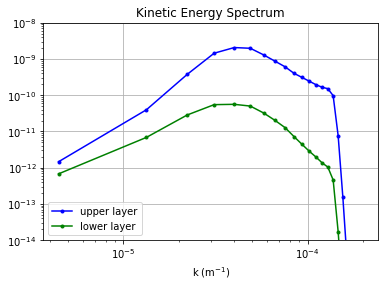

In [6]:
kr, kespec_upper = tools.calc_ispec(m, m_ds.KEspec.isel(lev=0).data)
_, kespec_lower = tools.calc_ispec(m, m_ds.KEspec.isel(lev=1).data)

plt.loglog(kr, kespec_upper, 'b.-', label='upper layer')
plt.loglog(kr, kespec_lower, 'g.-', label='lower layer')
plt.legend(loc='lower left')
plt.ylim([1e-14,1e-8])
plt.xlabel(r'k (m$^{-1}$)'); plt.grid()
plt.title('Kinetic Energy Spectrum');

We can also plot the spectral fluxes of energy and enstrophy. 

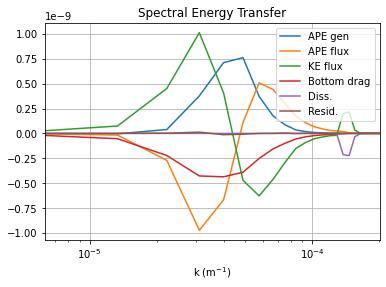

In [7]:
kr, APEgenspec = tools.calc_ispec(m, m_ds.APEgenspec.data)
_, APEflux     = tools.calc_ispec(m, m_ds.APEflux.data)
_, KEflux      = tools.calc_ispec(m, m_ds.KEflux.data)
_, KEfrictionspec = tools.calc_ispec(m, m_ds.KEfrictionspec.data)
_, Dissspec    = tools.calc_ispec(m, m_ds.Dissspec.data)

ebud = [ APEgenspec,
         APEflux,
         KEflux,
         KEfrictionspec,
         Dissspec]
ebud.append(-np.vstack(ebud).sum(axis=0))
ebud_labels = ['APE gen','APE flux','KE flux','Bottom drag','Diss.','Resid.']
[plt.semilogx(kr, term) for term in ebud]
plt.legend(ebud_labels, loc='upper right')
plt.xlim([m_ds.k[1:].min(), m_ds.k.max()])
plt.xlabel(r'k (m$^{-1}$)'); plt.grid()
plt.title('Spectral Energy Transfer');

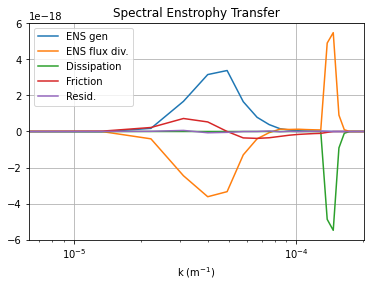

In [8]:
_, ENSflux    = tools.calc_ispec(m, m_ds.ENSflux.data.squeeze())
_, ENSgenspec = tools.calc_ispec(m, m_ds.ENSgenspec.data.squeeze())
_, ENSfrictionspec = tools.calc_ispec(m, m_ds.ENSfrictionspec.data.squeeze())
_, ENSDissspec = tools.calc_ispec(m, m_ds.ENSDissspec.data.squeeze())

ebud = [ ENSgenspec,
         ENSflux,
         ENSDissspec,
         ENSfrictionspec]
ebud.append(-np.vstack(ebud).sum(axis=0))
ebud_labels = ['ENS gen','ENS flux div.','Dissipation','Friction','Resid.']
[plt.semilogx(kr, term) for term in ebud]
plt.legend(ebud_labels, loc='best')
plt.xlim([m_ds.k[1:].min(), m_ds.k.max()])
plt.xlabel(r'k (m$^{-1}$)'); plt.grid()
plt.title('Spectral Enstrophy Transfer');